# Sample weights

## Objetivos

- Revisar algunos algortimos de Advances in Financial Machine Learning. Capítulos (2, 3 y) 4 (y algo del 20).
- Tópicos de Sample Weights.


## Bibliografia

- Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley

## Recursos

- Python 3.7+
- Jupyter notebook.
- Pandas
- numpy
- matplotlib

## Descripcion

En la siguiente notebook vamos a seguir la linea de trabajo del capítulo 4 del libro.
A partir de un dataset descargado de Yahoo Finance del ETF [MTUM](https://www.ishares.com/us/products/251614/ishares-msci-usa-momentum-factor-etf) vamos a
generar labels de entrada y salida con el método de la triple frontera:

- Frontera de profit taking (frontera horizontal superior)
- Frontera de stop loss (frontera horizontal inferior)
- Frontera temporal (frontera vertical)

Luego, vamos a computar los pesos a cada sample según la superposición de eventos que
ocurran entre $t_{0_i}$ (evento de nuestra estrategia) y $t_{1_i}$ (vertical barrier)
del evento $i$.

Dichos pesos los vamos a ponderar temporalmente luego para que los eventos más recientes
impacten más respecto de los anteriores.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# %load mpfin.py
import multiprocessing as mp
import datetime as dt
import time
import sys

def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    multiprocessing snippet [20.7]
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func

    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out


def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts

import datetime as dt

def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return

def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out


In [3]:
# %load labelling.py
import numpy as np
import pandas as pd

def getDailyVol(close, span0=100):
    '''
    Computes the daily volatility of price returns.
    It takes a closing price series, applies a diff sample to sample
    (assumes each sample is the closing price), computes an EWM with 
    `span0` samples and then the standard deviation of it.
    
    See Advances in Financial Analytics, snippet 3.1
    
    @param[in] close A series of prices where each value is the closing price of an asset.
               The index of the series must be a valid datetime type.
    @param[in] span0 The sample size of the EWM.
    @return A pandas series of daily return volatility.
    '''
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values-1 # Daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

def getVerticalBarrier(tEvents, close, numDays=0):
    """
    Adding a Vertical Barrier
    For each index in t_events, it finds the timestamp of the next price bar at or immediately after
    a number of days num_days. This vertical barrier can be passed as an optional argument t1 in get_events.
    This function creates a series that has all the timestamps of when the vertical barrier would be reached.
    
    Advances in Financial Machine Learning, Snippet 3.4 page 49.
    
    @param tEvents A pd.DateTimeIndex of events.
    @param close A pd.Series of close prices.
    @param numDays The number of days to add for vertical barrier.
    @return A pd.Series of Timestamps of vertical barriers
    """
    verticalBarrier = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    verticalBarrier = verticalBarrier[verticalBarrier < close.shape[0]]
    return pd.Series(close.index[verticalBarrier], index = tEvents[:verticalBarrier.shape[0]]) # NaNs at the end

def applyPtSlOnT1(close, events, ptSl, molecule):
    '''
    Apply stop loss/profit taking, if it takes place before t1 (vertical barrier)
    (end of event).
    
    Advances in Financial Machine Learning, snippet 3.2 page 45.
    @param close
    @param events
    @param ptSl
    @param molecule
    @return
    '''
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) # NaNs
    
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl=pd.Series(index=events.index) # NaNs
    
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc,'side'] # path returns
        out.loc[loc,'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt'] = df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
        side_, ptSl_= side.loc[trgt.index],ptSl[:2]
    events = (pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1) .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def getBinsOld(events,close):
    # Snippet 3.5
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # Where out index and t1 (vertical barrier) intersect label 0
    # See page 49, it is a suggested exercise.
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out


def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    
    Snippet 3.7
    
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    
    @param events It's a dataframe whose 
      - index is event's starttime
      - Column t1 is event's endtime
      - Column trgt is event's target
      - Column side (optional) implies the algo's position side.
    @param close It's a close price series.
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:
        out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out


def dropLabels(events, minPct=.05):
    '''
    Takes a dataframe of events and removes those labels that fall
    below minPct (minimum percentil).
    
    Snippet 3.8
    
    @param events An events dataframe, such as the output of getBins()
    @param minPct The minimum percentil of rare labels to have.
    @return The input @p events dataframe but filtered.
    '''
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [4]:
# %load events.py
def cusumFilterEvents(close, threshold):
    '''
    Symmetric CUSUM Filter.
    It is a quality-control method, designed to detect a shift in
    the mean value of the measured quantity away from a target value.
    The value of each filter is:
      S^{+}_t = max{0, S^{+}_{t-1} + y_t - E_{t-1}[y_t]}, S^{+}_0 = 0
      S^{-}_t = mix{0, S^{-}_{t-1} + y_t - E_{t-1}[y_t]}, S^{-}_0 = 0
      S_t = max{S^{+}_t, -S^{-}_t}

    See Advances in Financial Analytics, snippet 2.4, page 39.


    @param close A price series.
    @param threshold A positive threshold to flag a positive or negative
           event when either S^{+}_t or S^{-}_t is greater than it.
    @return A subset of the @p close index series where the events of
            filter are triggered.
    '''
    tEvents = []
    sPos = 0
    sNeg = 0
    
    diff = close.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sNeg < -threshold:
            sNeg = 0
            tEvents.append(i)
        elif sPos > threshold:
            sPos = 0
            tEvents.append(i)
    return pd.to_datetime(tEvents)


def getEwmDf(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a close prices dataframe with three columns, where:
    - Column "close" is the `close` price.
    - Column "fast" is the `fast` EWM with @p fast_window_num_days days window size.
    - Column "slow" is the `slow` EWM with @p slow_window_num_days days window size.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A dataframe as described above.
    '''
    close_df = (pd.DataFrame()
                .assign(close=close)
                .assign(fast=close.ewm(fast_window_num_days).mean())
                .assign(slow=close.ewm(slow_window_num_days).mean()))
    return close_df

def get_up_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

def getEwmEvents(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a pandas series from @p close price series whose events are generated
    from the EWM fast and slow signal crosses. When the fast signal crosses with a
    positive slope the slow signal a "1" is flagged and when the opposite happens
    a "-1" is flagged.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A pandas series of events of buy and sell signals.
    '''
    close_df = getEwmDf(close, fast_window_num_days, slow_window_num_days)
    up_events = get_up_cross(close_df)
    down_events = get_down_cross(close_df)
    side_up = pd.Series(1, index=up_events.index)
    side_down = pd.Series(-1, index=down_events.index)
    return pd.concat([side_up,side_down]).sort_index()
    

In [5]:
# %load sample_weights.py
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    
    Any event that starts before t1[modelcule].max() impacts the count.
    
    See Advances in Financial Analytics, snippet 4.1, page 60.
    
    @param closeIdx An index series of close prices. It must be related with `t1`.
    @param t1 An index series of vertical barrier events.
    @param molecule Event' series index.
           molecule[0] is the date of the first event on which the weight will be computed.
           molecule[-1] is the date of the last event on which the weight will be computed.
    @return A series with overlaps counts whose index is the same as t1.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():
        count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]


def mpSampleTW(t1,numCoEvents,molecule):
    '''
    Computes the sample weight of an event as the reciprocal of the hsrmonic average
    of c_t over the event's lifespan.
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    
    @param t1 An index series of vertical barrier events.
    @param numCoEvents The output of mpNumCoEvents()
    @param molecule Event' series index.
    @return A series of weights for each event in t1.
    '''
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

def mpSampleW(t1,numCoEvents,close,molecule):
    '''
    Derive sample weight by return attribution
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    ''' 
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

def getTimeDecay(tW,clfLastW=1.):
    '''
    Apply piecewise-linear decay to observed uniqueness (tW)
    Newest observation gets weight=1, oldest observation gets weight=clfLastW
    '''
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    # print(const,slope)
    return clfW

def getIndMatrix(barIx,t1):
    '''
    Get Indicator matrix
    
    See Advances in Financial Analytics, snippet 4.3, page 64.
    '''
    indM=(pd.DataFrame(0,index=barIx,columns=range(t1.shape[0])))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

def getAvgUniqueness(indM):
    '''
    Average uniqueness from indicator matrix
    
    See Advances in Financial Analytics, snippet 4.4, page 65.
    '''
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # avg. uniqueness
    return avgU

def seqBootstrap(indM,sLength=None):
    '''
    Generate a sample via sequential bootstrap
    
    See Advances in Financial Analytics, snippet 4.5, page XX.
    '''
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

### 1.- Exploración del dataset

- Levantamos el datset desde un CSV
- Nota: indexamos el dataset con la columna de fechas para poder aprovechar las funciones del libro
  como estan dadas.
- Describimos el dataset.
- Mostramos la evolución de las series.


A saber, las columnas son:

- `Date`: es la fecha que aplica una estampa temporal a la fila.
- `Open`: es el precio en USD al que abre la cotización del fondo.
- `High`: es el mayor valor en USD que alcanza la cotización del fondo.
- `Low`: es el menor valor en USD que alcanza la cotización del fondo.
- `Close`: es el valor de cierre en USD que alcanza la cotización del fondo.
- `Adj Close`: es el precio ajustado que alcanzan algunos activos producto de multiplicadores por regalías y dividendos. Ver https://help.yahoo.com/kb/SLN28256.html para una descripción más detallada al respecto.
- `Volume`: cantidad total de USD operados.

In [6]:
MTUM_PATH = '../datasets/mtum.csv'

In [7]:
# Función que permite convertir el formato de las fechas como string
# en un objeto de fecha.
string_to_date = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")

In [8]:
mtum = pd.read_csv(MTUM_PATH, parse_dates=['Date'], date_parser=string_to_date, index_col='Date')

In [9]:
mtum.head() # Filas iniciales del dataset.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-04-18,50.919998,50.919998,50.919998,50.919998,46.707516,400
2013-04-19,50.919998,50.919998,50.919998,50.919998,46.707516,0
2013-04-22,50.919998,50.919998,50.919998,50.919998,46.707516,0
2013-04-23,52.220001,52.220001,52.220001,52.220001,47.899956,600
2013-04-24,51.700001,51.700001,51.560001,51.560001,47.294567,1100


In [10]:
mtum.tail() # Filas finales del dataset.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-09,143.300003,145.440002,142.380005,144.600006,144.600006,1681900
2020-09-10,146.000000,146.589996,141.339996,142.020004,142.020004,614100
2020-09-11,143.250000,143.539993,139.889999,141.529999,141.529999,616800
2020-09-14,143.339996,145.320007,143.070007,144.669998,144.669998,677400
2020-09-15,146.649994,147.419998,146.089996,146.979996,146.979996,561300


In [11]:
# [#Filas, #Columnas]
mtum.shape[0], mtum.shape[1]

(1867, 6)

In [12]:
# Tipo de dato de cada columna.
mtum.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

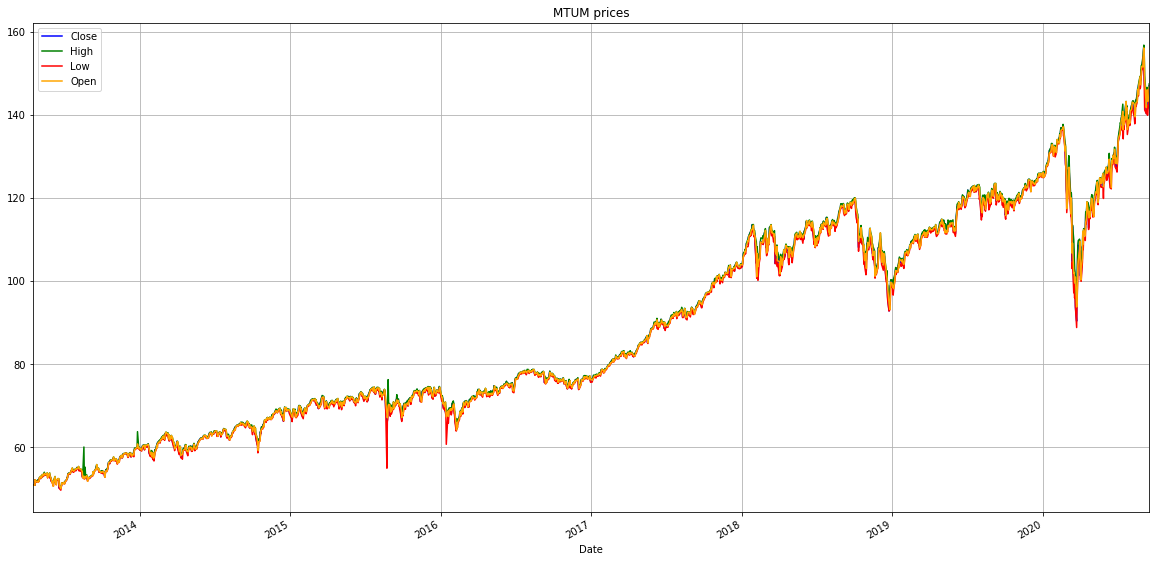

In [13]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
mtum.plot(kind='line',y='Close', color='blue', ax=ax)
mtum.plot(kind='line',y='High', color='green', ax=ax)
mtum.plot(kind='line',y='Low', color='red', ax=ax)
mtum.plot(kind='line',y='Open', color='orange', ax=ax)
plt.title('MTUM prices')
plt.grid()
plt.show()

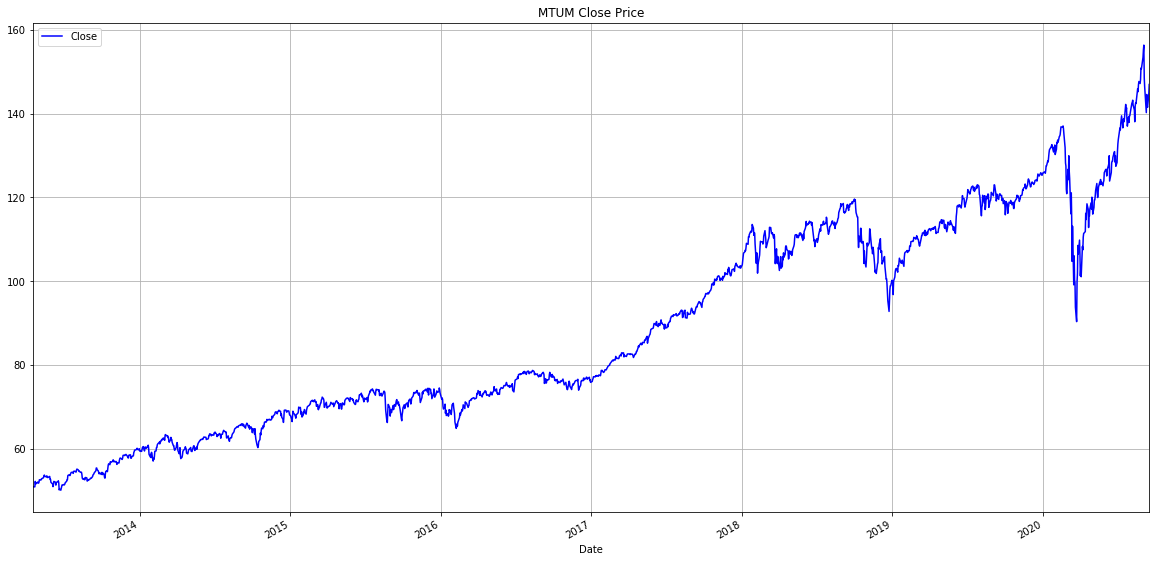

In [14]:
# En particular los va a interesar el precio de cierre.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
mtum.plot(kind='line',y='Close', color='blue', ax=ax)
plt.title('MTUM Close Price')
plt.grid()
plt.show()

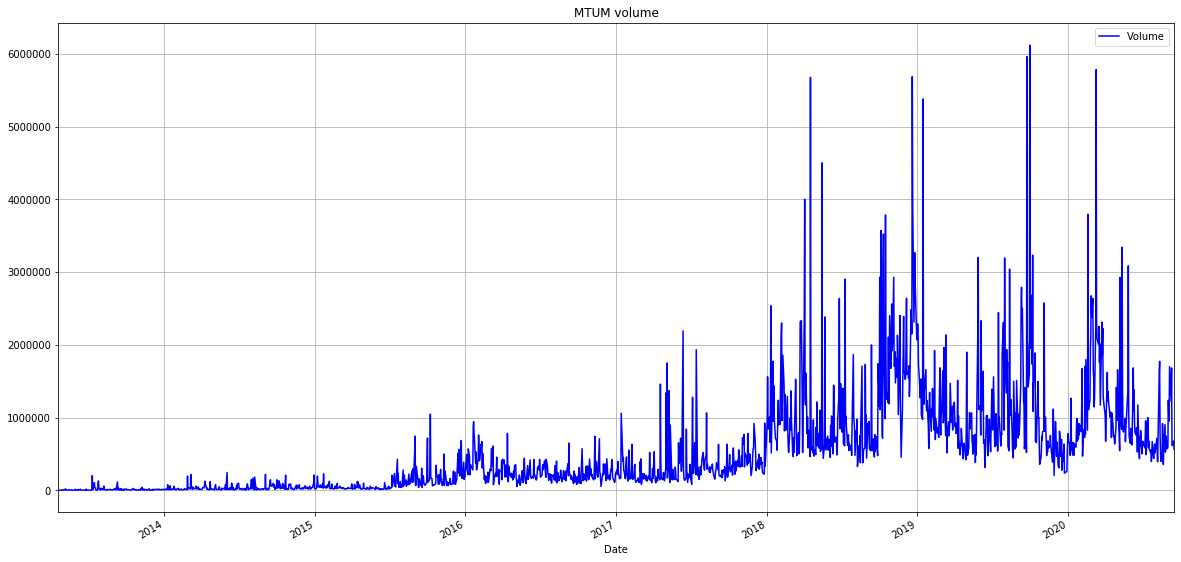

In [15]:
# Solo para comparar, miramos el volumen operado.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
mtum.plot(kind='line',y='Volume', color='blue', ax=ax)
plt.title('MTUM volume')
plt.grid()
plt.show()

### 2.- Desarrollo con labels

ver [Labelling sec.2](https://github.com/agalbachicar/financial_analytics/blob/master/notebooks/labelling.ipynb) para más detalle.

In [16]:
# Computamos la volatilidad diaria, suavizada con una media
# movil pesada de 50 dias (arbitraria, también se podria aprender)
daily_vol = getDailyVol(close=mtum['Close'], span0=50)

In [17]:
# Volatilidad media.
daily_vol.mean()

0.012651033080532394

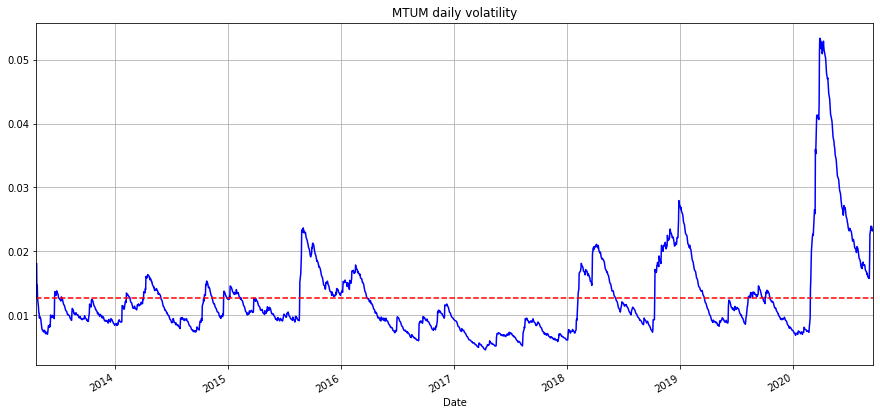

In [18]:
# Graficamos la volatilidad a lo largo de la historia del ETF.
# La línea roja muestra el valor medio.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
daily_vol.plot(kind='line',y='dailyVol', color='blue', ax=ax)
ax.axhline(daily_vol.mean(),ls='--',color='r')
plt.title('MTUM daily volatility')
plt.grid()
plt.show()

In [19]:
# Usamos CUSUM simetrico como generador de eventos.
# Usamos la media de la volatilidad como umbral que nos indique los eventos
# en que el que operaremos.
tEvents = cusumFilterEvents(mtum['Close'], threshold=daily_vol.mean())
tEvents

DatetimeIndex(['2013-04-23', '2013-04-24', '2013-04-25', '2013-04-26',
               '2013-04-29', '2013-04-30', '2013-05-01', '2013-05-02',
               '2013-05-03', '2013-05-06',
               ...
               '2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11',
               '2020-09-14', '2020-09-15'],
              dtype='datetime64[ns]', length=1837, freq=None)

In [20]:
# Definimos el tiempo de la barrera vertical. Esto es algo a optimizar
# y debe ajustarse en conjunto con los valores de retorno PT y SL.
num_days = 6

In [21]:
# Computamos las marcas temporales de la ventana. Para cada evento
# en tEvents (inicio de la ventana), obtenemos el final de la ventana.
t1 = getVerticalBarrier(tEvents, mtum['Close'], numDays=num_days)
t1

2013-04-23   2013-04-29
2013-04-24   2013-04-30
2013-04-25   2013-05-01
2013-04-26   2013-05-02
2013-04-29   2013-05-06
                ...    
2020-09-02   2020-09-08
2020-09-03   2020-09-09
2020-09-04   2020-09-10
2020-09-08   2020-09-14
2020-09-09   2020-09-15
Name: Date, Length: 1833, dtype: datetime64[ns]

In [22]:
# Definimos las bandas de PT y SL.
ptsl = [0.015, 0.015]
target = daily_vol
# Seleccionamos el mínimo retorno considerado.
minRet = 0.01
# Numero de CPUs para el procesamiento en paralelo. 
cpus = 4

In [23]:
# Generamos los eventos de la triple frontera. En esta funcion obtenemos
# un dataframe cuyo indice es cuando ocurre el evento y tiene 2 columnasÑ
# - t1: momento en el que sucede el evento.
# - trgt: retorno obtenido en ese momento.
triple_barrier_events = getEvents(mtum['Close'],tEvents,ptsl,target,minRet,cpus,t1=t1)
triple_barrier_events

2020-09-27 18:37:35.030048 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.


,t1,trgt
2013-04-23,2013-04-24,0.018053
2013-04-24,2013-04-25,0.012640
2013-04-25,2013-04-26,0.014695
2013-04-26,2013-04-29,0.012688
2013-04-29,2013-04-30,0.011238
...,...,...
2020-09-09,2020-09-10,0.023639
2020-09-10,2020-09-11,0.023281
2020-09-11,2020-09-14,0.023249
2020-09-14,2020-09-15,0.023180


In [24]:
# Obtenemos los labels! Los labels nos dan la siguiente informacion:
# - Indice: momento en el que ocurre el evento segun nuestra estrategia.
# - Columna ret: el retorno que vamos a obtener.
# - Columna bin: lo que sucede con la señal de precio:
#   - 1: la señal impacta la barrera de profit taking (horizontal superior).
#   - 0: la señal impacta la barrera vertical (no se hace nada).
#   - -1: la señal impacta la barrea de stop loss (horizontal inferior).
labels = getBinsOld(triple_barrier_events, mtum['Close'])
labels

,ret,bin
2013-04-23,-0.012639,-1.0
2013-04-24,0.004849,1.0
2013-04-25,-0.000772,-1.0
2013-04-26,0.005795,1.0
2013-04-29,-0.004417,0.0
...,...,...
2020-09-08,0.030943,0.0
2020-09-09,-0.017842,0.0
2020-09-10,-0.003450,0.0
2020-09-11,0.022186,1.0


In [25]:
# Una pequeña tabla de contención que nos indica como se distribuyen
# los labels.
labels['bin'].value_counts()

 0.0    803
 1.0    131
-1.0     92
Name: bin, dtype: int64

## 3.- Cómputo de sample weights



In [26]:
numCoEvents = mpPandasObj(mpNumCoEvents,('molecule',triple_barrier_events.index),cpus,
                          closeIdx=mtum.index,t1=triple_barrier_events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(mtum['Close'].index).fillna(0)

out=pd.DataFrame()
out['tW'] = mpPandasObj(mpSampleTW,('molecule',triple_barrier_events.index),cpus,
                        t1=triple_barrier_events['t1'],numCoEvents=numCoEvents)
out['w'] = mpPandasObj(mpSampleW,('molecule',triple_barrier_events.index),cpus,
                       t1=triple_barrier_events['t1'],numCoEvents=numCoEvents,close=mtum['Close'])
out['w'] *= out.shape[0]/out['w'].sum()
out

2020-09-27 18:37:35.889119 100.0% mpNumCoEvents done after 0.01 minutes. Remaining 0.0 minutes.
2020-09-27 18:37:36.214289 100.0% mpSampleTW done after 0.0 minutes. Remaining 0.0 minutes.
2020-09-27 18:37:36.792796 100.0% mpSampleW done after 0.01 minutes. Remaining 0.0 minutes.


,tW,w
2013-04-23,0.75,2.807802
2013-04-24,0.50,0.587055
2013-04-25,0.50,0.302721
2013-04-26,0.50,0.372814
2013-04-29,0.50,0.100635
...,...,...
2020-09-09,0.50,0.928735
2020-09-10,0.50,1.598248
2020-09-11,0.50,1.376880
2020-09-14,0.50,2.814094


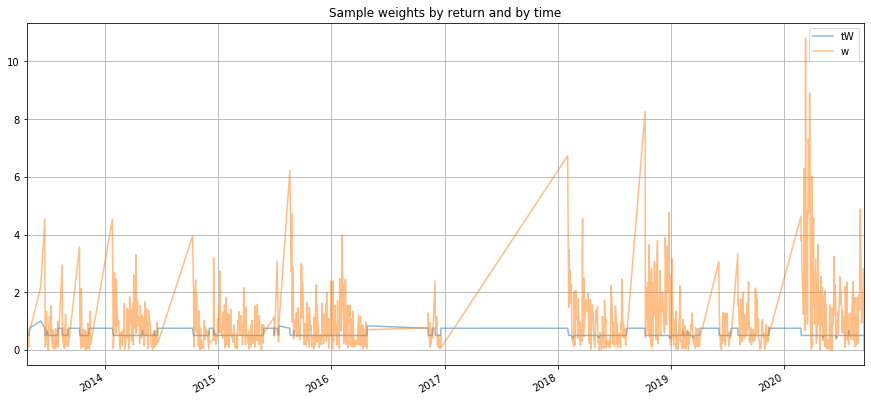

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
out.plot(alpha=0.5, ax=ax)
plt.title('Sample weights by return and by time')
plt.grid()
plt.show()

In [28]:
coEvents_std = (
    pd.DataFrame()
    .assign(
        numCoEvents = numCoEvents,
        std = daily_vol)
)
coEvents_std

,numCoEvents,std
Date,,
2013-04-18,0.0,NaN
2013-04-19,0.0,NaN
2013-04-22,0.0,NaN
2013-04-23,1.0,0.018053
2013-04-24,2.0,0.012640
...,...,...
2020-09-09,2.0,0.023639
2020-09-10,2.0,0.023281
2020-09-11,2.0,0.023249


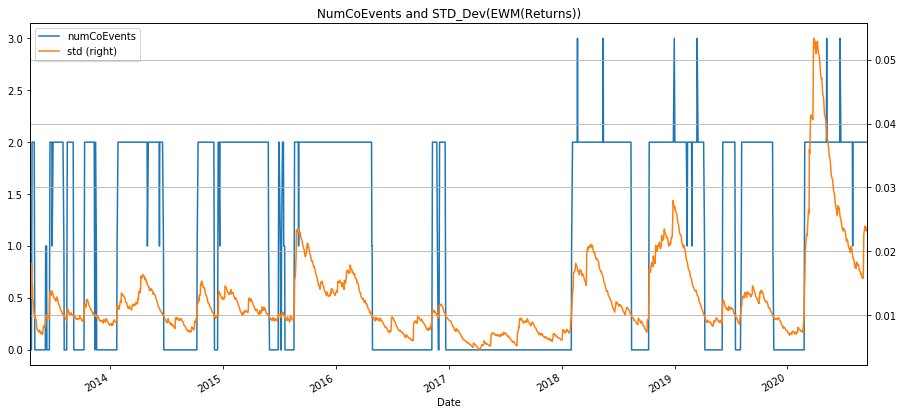

In [29]:
fig, ax = plt.subplots(figsize=(15,7))
coEvents_std['numCoEvents'].plot(legend=True, ax=ax)
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax)
plt.title('NumCoEvents and STD_Dev(EWM(Returns))')
plt.grid()
plt.show()

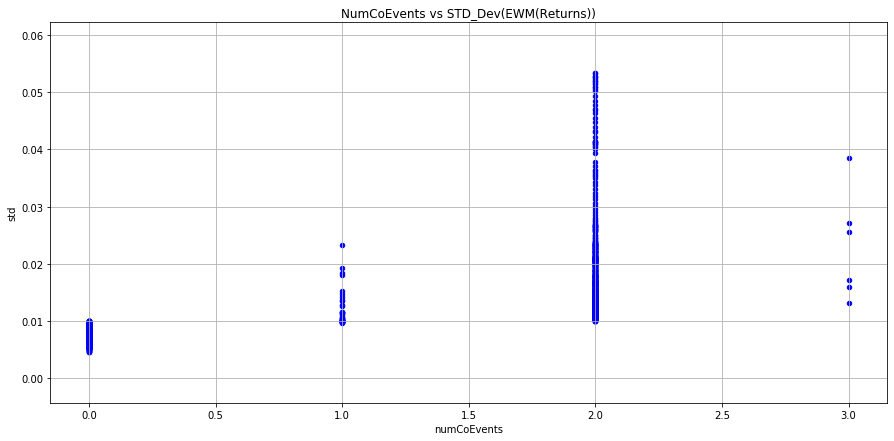

In [30]:
fig, ax = plt.subplots(figsize=(15,7))
coEvents_std.plot.scatter(x='numCoEvents', y='std', c='blue', ax=ax)
plt.title('NumCoEvents vs STD_Dev(EWM(Returns))')
plt.grid()
plt.show()

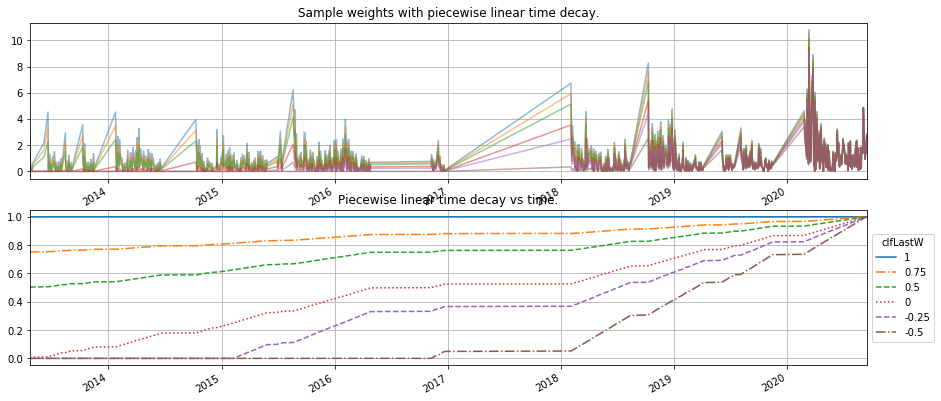

In [31]:
fig, ax = plt.subplots(2, figsize=(15,7))

fs = [1,.75,.5,0,-.25,-.5]
ls = ['-','-.','--',':','--','-.']

for lstW, l in zip(fs,ls):
    decayFactor = getTimeDecay(out['tW'].dropna(), clfLastW=lstW)
    ((out['w'].dropna()*decayFactor).plot(ax=ax[0],alpha=0.5))
    ax[0].grid()
    ax[0].title.set_text('Sample weights with piecewise linear time decay.')
    
    s = (pd.Series(1,index=out['w'].dropna().index)*decayFactor)
    s.plot(ax=ax[1], ls=l, label=str(lstW))
    ax[1].grid()
    ax[1].title.set_text('Piecewise linear time decay vs time.')
    
ax[1].legend(title='clfLastW',  loc='center left', bbox_to_anchor=(1, 0.5))